<a href="https://colab.research.google.com/github/danlingzhou16/stat390/blob/GraceZhu/Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [50]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true-y_pred)/y_true)) * 100

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [32]:
train = pd.read_csv('/content/gdrive/MyDrive/complete covid dataset/train_final.csv', parse_dates = ['date'])
test = pd.read_csv('/content/gdrive/MyDrive/complete covid dataset/test_final.csv', parse_dates = ['date'])

In [54]:
train.head()

,Unnamed: 0.1,Unnamed: 0,date,location_key_x,country_code,new_deceased,cumulative_deceased,population,population_male,population_female,...,new_confirmed_min7,day_name,day_of_week,quarter,month,year,dayofyear,dayofmonth,weekofyear,season
0,0,0,2020-01-22,US_AK,US,0.0,0.0,733391.0,424916.0,391925.0,...,NaN,Wednesday,2,1,1,2020,22,22,4,Winter
1,1,1,2020-01-23,US_AK,US,0.0,0.0,733391.0,424916.0,391925.0,...,NaN,Thursday,3,1,1,2020,23,23,4,Winter
2,2,2,2020-01-24,US_AK,US,0.0,0.0,733391.0,424916.0,391925.0,...,NaN,Friday,4,1,1,2020,24,24,4,Winter
3,3,3,2020-01-25,US_AK,US,0.0,0.0,733391.0,424916.0,391925.0,...,NaN,Saturday,5,1,1,2020,25,25,4,Winter
4,4,4,2020-01-26,US_AK,US,0.0,0.0,733391.0,424916.0,391925.0,...,NaN,Sunday,6,1,1,2020,26,26,4,Winter


In [33]:
train_col_of_interest = train[['date','country_code', 'location_key_x', 'new_confirmed']]
test_col_of_interest = test[['date','country_code', 'location_key_x', 'new_confirmed']]

In [34]:
# group by countries
train_col_of_interest_gp = train_col_of_interest.groupby(['country_code','date'])
test_col_of_interest_gp = test_col_of_interest.groupby(['country_code','date'])

In [35]:
train_agg = train_col_of_interest_gp.agg('sum')
train_agg.reset_index(level = 'country_code', inplace = True)
test_agg = test_col_of_interest_gp.agg('sum')
test_agg.reset_index(level = 'country_code', inplace = True)

<ipython-input-35-d0a6c7074d1a>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  train_agg = train_col_of_interest_gp.agg('sum')
<ipython-input-35-d0a6c7074d1a>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  test_agg = test_col_of_interest_gp.agg('sum')


In [36]:
train_agg_us = train_agg.loc[train_agg.country_code == 'US','new_confirmed']
train_agg_us_df = pd.DataFrame(train_agg_us)
test_agg_us = test_agg.loc[test_agg.country_code == 'US','new_confirmed']
test_agg_us_df = pd.DataFrame(test_agg_us)

In [37]:
train_us=train_agg_us_df.iloc[:]['new_confirmed']
test_us=test_agg_us_df.iloc[: ]['new_confirmed']
print(train_us.shape, test_us.shape)

(719,) (258,)


In [52]:
train_us.head()

date
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Name: new_confirmed, dtype: float64

In [38]:
model = prophet.Prophet().fit(train_us.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkyy4poi2/9kid05po.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkyy4poi2/bz9qgnt2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48081', 'data', 'file=/tmp/tmpkyy4poi2/9kid05po.json', 'init=/tmp/tmpkyy4poi2/bz9qgnt2.json', 'output', 'file=/tmp/tmpkyy4poi2/prophet_modelsvbdlo9r/prophet_model-20231110201201.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:12:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:12:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [39]:
train_pred=model.predict(train_us.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
train_pred.head()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,
2020-01-13,-13626.528931,-67893.864816,63686.511944,-13626.528931,-13626.528931,10871.836988,10871.836988,10871.836988,10871.836988,10871.836988,10871.836988,0.0,0.0,0.0,-2754.691942
2020-01-14,-13290.680926,-73547.896999,59564.644290,-13290.680926,-13290.680926,2104.942909,2104.942909,2104.942909,2104.942909,2104.942909,2104.942909,0.0,0.0,0.0,-11185.738017
2020-01-15,-12954.832921,-67633.396296,64568.292264,-12954.832921,-12954.832921,9122.647027,9122.647027,9122.647027,9122.647027,9122.647027,9122.647027,0.0,0.0,0.0,-3832.185894
2020-01-16,-12618.984917,-70956.099070,55116.994499,-12618.984917,-12618.984917,7341.185615,7341.185615,7341.185615,7341.185615,7341.185615,7341.185615,0.0,0.0,0.0,-5277.799302
2020-01-17,-12283.136912,-67186.675239,65039.806877,-12283.136912,-12283.136912,10048.997440,10048.997440,10048.997440,10048.997440,10048.997440,10048.997440,0.0,0.0,0.0,-2234.139472


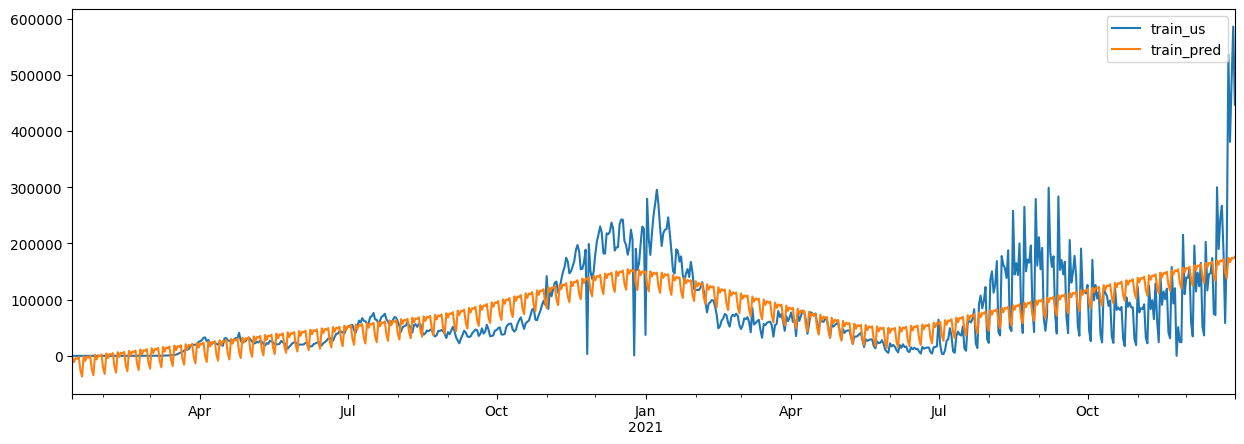

In [40]:
pd.concat([train_us,train_pred['yhat']], axis=1).plot(figsize=(15,5))
plt.legend(['train_us', 'train_pred'])

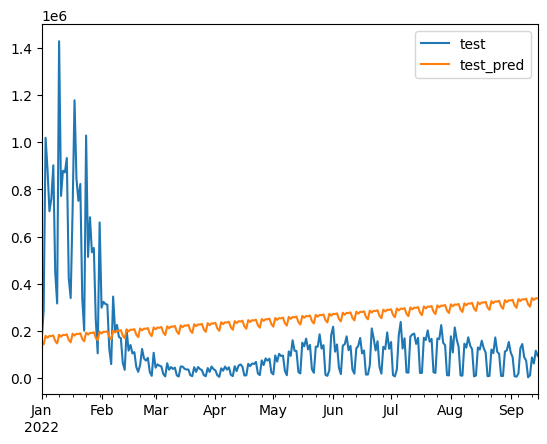

In [41]:
test_pred=model.predict(test_us.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
pd.concat([test_us,test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])

In [42]:
test_pred.reset_index().head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-01-01,166967.293952,86633.378606,218709.853339,166967.293952,166967.293952,-14263.691249,-14263.691249,-14263.691249,-14263.691249,-14263.691249,-14263.691249,0.0,0.0,0.0,152703.602703
1,2022-01-02,167602.171228,74810.109498,208205.008290,167602.171228,167602.171228,-25225.918730,-25225.918730,-25225.918730,-25225.918730,-25225.918730,-25225.918730,0.0,0.0,0.0,142376.252498
2,2022-01-03,168237.048504,112412.576117,245583.349102,168237.048504,168237.048504,10871.836988,10871.836988,10871.836988,10871.836988,10871.836988,10871.836988,0.0,0.0,0.0,179108.885492
3,2022-01-04,168871.925780,104418.516332,238864.131360,168871.925780,168871.925780,2104.942909,2104.942909,2104.942909,2104.942909,2104.942909,2104.942909,0.0,0.0,0.0,170976.868689
4,2022-01-05,169506.803056,112851.018902,240715.980606,169506.803056,169506.803056,9122.647027,9122.647027,9122.647027,9122.647027,9122.647027,9122.647027,0.0,0.0,0.0,178629.450083


In [43]:
# Evaluate the model with error metrics

In [47]:
np.sqrt(mean_squared_error(y_true = test_us,
                          y_pred = test_pred['yhat']))

261479.0080693557

In [48]:
mean_absolute_error(y_true = test_us,
                    y_pred = test_pred['yhat'])

211422.24663074902

In [51]:
mean_absolute_percentage_error(y_true = test_us,
                    y_pred = test_pred['yhat'])

609.3216657333545

In [60]:
# Add aditional regressors
pd.set_option('display.max_columns', None)
train.head()

,Unnamed: 0.1,Unnamed: 0,date,location_key_x,country_code,new_deceased,cumulative_deceased,population,population_male,population_female,latitude,longitude,area_sq_km,life_expectancy,mobility_workplaces,aggregation_level,new_persons_fully_vaccinated,cumulative_persons_fully_vaccinated,gdp_usd,gdp_per_capita_usd,AG.LND.AGRI.K2,AG.LND.AGRI.ZS,AG.LND.ARBL.HA,AG.LND.ARBL.HA.PC,AG.LND.ARBL.ZS,AG.LND.CROP.ZS,AG.LND.FRST.K2,AG.LND.FRST.ZS,AG.LND.TOTL.K2,AG.PRD.CROP.XD,AG.PRD.FOOD.XD,AG.PRD.LVSK.XD,AG.SRF.TOTL.K2,BX.KLT.DINV.CD.WD,EG.ELC.ACCS.RU.ZS,EG.ELC.ACCS.UR.ZS,EG.ELC.ACCS.ZS,EG.ELC.RNEW.ZS,EG.FEC.RNEW.ZS,EN.ATM.CO2E.GF.KT,EN.ATM.CO2E.GF.ZS,EN.ATM.CO2E.KT,EN.ATM.CO2E.LF.KT,EN.ATM.CO2E.LF.ZS,EN.ATM.CO2E.PC,EN.ATM.CO2E.SF.KT,EN.ATM.CO2E.SF.ZS,EN.ATM.PM25.MC.M3,EN.ATM.PM25.MC.T1.ZS,EN.ATM.PM25.MC.T2.ZS,EN.ATM.PM25.MC.T3.ZS,EN.ATM.PM25.MC.ZS,EN.BIR.THRD.NO,EN.FSH.THRD.NO,EN.HPT.THRD.NO,EN.MAM.THRD.NO,EN.POP.DNST,ER.FSH.CAPT.MT,ER.FSH.PROD.MT,ER.LND.PTLD.ZS,ER.PTD.TOTL.ZS,IP.JRN.ARTC.SC,IT.CEL.SETS,IT.CEL.SETS.P2,IT.MLT.MAIN,IT.MLT.MAIN.P2,IT.NET.BBND,IT.NET.BBND.P2,IT.NET.SECR,IT.NET.SECR.P6,IT.NET.USER.ZS,NV.IND.TOTL.CN,NV.IND.TOTL.ZS,NY.ADJ.AEDU.GN.ZS,NY.ADJ.DCO2.CD,NY.ADJ.DCO2.GN.ZS,NY.ADJ.DKAP.CD,NY.ADJ.DMIN.CD,NY.ADJ.DMIN.GN.ZS,NY.ADJ.DNGY.CD,NY.GDP.DEFL.KD.ZG,NY.GDP.DEFL.KD.ZG.AD,NY.GDP.DEFL.ZS,NY.GDP.DEFL.ZS.AD,NY.GDP.FRST.RT.ZS,NY.GDP.MINR.RT.ZS,NY.GDP.MKTP.CD,NY.GDP.MKTP.CN,NY.GDP.MKTP.CN.AD,NY.GDP.MKTP.KD,NY.GDP.MKTP.KD.ZG,NY.GDP.MKTP.KN,NY.GDP.PCAP.CD,NY.GDP.PCAP.CN,NY.GDP.PCAP.KD,NY.GDP.PCAP.KD.ZG,NY.GDP.PCAP.KN,NY.GDP.PETR.RT.ZS,NY.GDP.TOTL.RT.ZS,NY.GNP.MKTP.CD,NY.GNP.MKTP.CN,NY.GNP.PCAP.CN,PA.NUS.ATLS,PA.NUS.PPP,SE.COM.DURS,SE.PRM.AGES,SE.PRM.DURS,SE.SEC.AGES,SE.SEC.DURS,SH.H2O.BASW.ZS,SH.STA.BASS.ZS,SH.STA.DIAB.ZS,SH.STA.ODFC.ZS,SH.TBS.CURE.ZS,SH.TBS.DTEC.ZS,SH.TBS.INCD,SM.POP.REFG.OR,SM.POP.TOTL,SM.POP.TOTL.ZS,SP.DYN.CBRT.IN,SP.DYN.CDRT.IN,SP.DYN.LE00.FE.IN,SP.DYN.LE00.IN,SP.DYN.LE00.MA.IN,SP.DYN.TFRT.IN,SP.POP.GROW,SP.POP.TOTL,SP.RUR.TOTL,SP.RUR.TOTL.ZG,SP.RUR.TOTL.ZS,SP.URB.GROW,SP.URB.TOTL,SP.URB.TOTL.IN.ZS,ST.INT.ARVL,ST.INT.RCPT.CD,TG.VAL.TOTL.GD.ZS,TM.QTY.MRCH.XD.WD,TM.UVI.MRCH.XD.WD,TM.VAL.MRCH.AL.ZS,TM.VAL.MRCH.CD.WT,TM.VAL.MRCH.HI.ZS,TM.VAL.MRCH.OR.ZS,TM.VAL.MRCH.R1.ZS,TM.VAL.MRCH.R2.ZS,TM.VAL.MRCH.R3.ZS,TM.VAL.MRCH.R4.ZS,TM.VAL.MRCH.R5.ZS,TM.VAL.MRCH.R6.ZS,TM.VAL.MRCH.RS.ZS,TM.VAL.MRCH.WL.CD,TM.VAL.MRCH.XD.WD,TT.PRI.MRCH.XD.WD,TX.QTY.MRCH.XD.WD,TX.UVI.MRCH.XD.WD,TX.VAL.MRCH.AL.ZS,TX.VAL.MRCH.CD.WT,TX.VAL.MRCH.HI.ZS,TX.VAL.MRCH.OR.ZS,TX.VAL.MRCH.R1.ZS,TX.VAL.MRCH.R2.ZS,TX.VAL.MRCH.R3.ZS,TX.VAL.MRCH.R4.ZS,TX.VAL.MRCH.R5.ZS,TX.VAL.MRCH.R6.ZS,TX.VAL.MRCH.RS.ZS,TX.VAL.MRCH.WL.CD,TX.VAL.MRCH.XD.WD,new_confirmed,new_confirmed_lag1,new_confirmed_lag3,new_confirmed_lag7,new_confirmed_mean1,new_confirmed_mean3,new_confirmed_mean7,new_confirmed_std1,new_confirmed_std3,new_confirmed_std7,new_confirmed_max1,new_confirmed_max3,new_confirmed_max7,new_confirmed_min1,new_confirmed_min3,new_confirmed_min7,day_name,day_of_week,quarter,month,year,dayofyear,dayofmonth,weekofyear,season
0,0,0,2020-01-22,US_AK,US,0.0,0.0,733391.0,424916.0,391925.0,64.0,-150.0,1717856.0,78.0,1.333333,1.0,0.0,0.0,2.137442e+13,65118.0,4058625.0,44.369068,152262500.0,0.471487,16.645404,0.284233,3103700.0,33.929786,9147420.0,122.19,122.32,109.7,9831510.0,3.108110e+11,100.0,100.0,100.0,13.228593,8.716936,1498556.22,29.933396,5006302.077,2127054.351,42.487535,15.502204,1323423.967,26.43516,7.409442,0.016435,0.054598,0.277273,3.34317,91.0,251.0,510.0,40.0,35.713622,4931017.0,5375386.0,12.993872,26.328084,422807.71,422000000.0,129.014008,109961000.0,33.617321,110568000.0,33.802893,40706354.0,124014.176075,87.266113,3.547889e+12,18.20794,4.39511,1.737862e+11,0.834013,3.283263e+12,9.505476e+09,0.045617,6.768216e+10,1.743652,1.743652,107.284538,107.284538,0.041949,0.071174,2.137442e+13,2.137442e+13,2.137442e+13,1.827317e+13,2.333577,1.992311e+13,65118.358333,65118.358333,55670.235709,1.849711,60696.871838,0.376622,0.711242,2.162500e+13,2.162500e+13,65881.75473

In [61]:
# group by countries
train_country = train.groupby(['country_code','date'])
test_country = test.groupby(['country_code','date'])
train_country_agg = train_country.agg('sum')
train_country_agg.reset_index(level = 'country_code', inplace = True)
test_country_agg = test_country.agg('sum')
test_country_agg.reset_index(level = 'country_code', inplace = True)

<ipython-input-61-bc410932a85f>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  train_country_agg = train_country.agg('sum')
<ipython-input-61-bc410932a85f>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  test_country_agg = test_country.agg('sum')


In [73]:
train_country_agg.reset_index().head()

,date,country_code,Unnamed: 0.1,Unnamed: 0,new_deceased,cumulative_deceased,population,population_male,population_female,latitude,longitude,area_sq_km,life_expectancy,mobility_workplaces,aggregation_level,new_persons_fully_vaccinated,cumulative_persons_fully_vaccinated,gdp_usd,gdp_per_capita_usd,AG.LND.AGRI.K2,AG.LND.AGRI.ZS,AG.LND.ARBL.HA,AG.LND.ARBL.HA.PC,AG.LND.ARBL.ZS,AG.LND.CROP.ZS,AG.LND.FRST.K2,AG.LND.FRST.ZS,AG.LND.TOTL.K2,AG.PRD.CROP.XD,AG.PRD.FOOD.XD,AG.PRD.LVSK.XD,AG.SRF.TOTL.K2,BX.KLT.DINV.CD.WD,EG.ELC.ACCS.RU.ZS,EG.ELC.ACCS.UR.ZS,EG.ELC.ACCS.ZS,EG.ELC.RNEW.ZS,EG.FEC.RNEW.ZS,EN.ATM.CO2E.GF.KT,EN.ATM.CO2E.GF.ZS,EN.ATM.CO2E.KT,EN.ATM.CO2E.LF.KT,EN.ATM.CO2E.LF.ZS,EN.ATM.CO2E.PC,EN.ATM.CO2E.SF.KT,EN.ATM.CO2E.SF.ZS,EN.ATM.PM25.MC.M3,EN.ATM.PM25.MC.T1.ZS,EN.ATM.PM25.MC.T2.ZS,EN.ATM.PM25.MC.T3.ZS,EN.ATM.PM25.MC.ZS,EN.BIR.THRD.NO,EN.FSH.THRD.NO,EN.HPT.THRD.NO,EN.MAM.THRD.NO,EN.POP.DNST,ER.FSH.CAPT.MT,ER.FSH.PROD.MT,ER.LND.PTLD.ZS,ER.PTD.TOTL.ZS,IP.JRN.ARTC.SC,IT.CEL.SETS,IT.CEL.SETS.P2,IT.MLT.MAIN,IT.MLT.MAIN.P2,IT.NET.BBND,IT.NET.BBND.P2,IT.NET.SECR,IT.NET.SECR.P6,IT.NET.USER.ZS,NV.IND.TOTL.CN,NV.IND.TOTL.ZS,NY.ADJ.AEDU.GN.ZS,NY.ADJ.DCO2.CD,NY.ADJ.DCO2.GN.ZS,NY.ADJ.DKAP.CD,NY.ADJ.DMIN.CD,NY.ADJ.DMIN.GN.ZS,NY.ADJ.DNGY.CD,NY.GDP.DEFL.KD.ZG,NY.GDP.DEFL.KD.ZG.AD,NY.GDP.DEFL.ZS,NY.GDP.DEFL.ZS.AD,NY.GDP.FRST.RT.ZS,NY.GDP.MINR.RT.ZS,NY.GDP.MKTP.CD,NY.GDP.MKTP.CN,NY.GDP.MKTP.CN.AD,NY.GDP.MKTP.KD,NY.GDP.MKTP.KD.ZG,NY.GDP.MKTP.KN,NY.GDP.PCAP.CD,NY.GDP.PCAP.CN,NY.GDP.PCAP.KD,NY.GDP.PCAP.KD.ZG,NY.GDP.PCAP.KN,NY.GDP.PETR.RT.ZS,NY.GDP.TOTL.RT.ZS,NY.GNP.MKTP.CD,NY.GNP.MKTP.CN,NY.GNP.PCAP.CN,PA.NUS.ATLS,PA.NUS.PPP,SE.COM.DURS,SE.PRM.AGES,SE.PRM.DURS,SE.SEC.AGES,SE.SEC.DURS,SH.H2O.BASW.ZS,SH.STA.BASS.ZS,SH.STA.DIAB.ZS,SH.STA.ODFC.ZS,SH.TBS.CURE.ZS,SH.TBS.DTEC.ZS,SH.TBS.INCD,SM.POP.REFG.OR,SM.POP.TOTL,SM.POP.TOTL.ZS,SP.DYN.CBRT.IN,SP.DYN.CDRT.IN,SP.DYN.LE00.FE.IN,SP.DYN.LE00.IN,SP.DYN.LE00.MA.IN,SP.DYN.TFRT.IN,SP.POP.GROW,SP.POP.TOTL,SP.RUR.TOTL,SP.RUR.TOTL.ZG,SP.RUR.TOTL.ZS,SP.URB.GROW,SP.URB.TOTL,SP.URB.TOTL.IN.ZS,ST.INT.ARVL,ST.INT.RCPT.CD,TG.VAL.TOTL.GD.ZS,TM.QTY.MRCH.XD.WD,TM.UVI.MRCH.XD.WD,TM.VAL.MRCH.AL.ZS,TM.VAL.MRCH.CD.WT,TM.VAL.MRCH.HI.ZS,TM.VAL.MRCH.OR.ZS,TM.VAL.MRCH.R1.ZS,TM.VAL.MRCH.R2.ZS,TM.VAL.MRCH.R3.ZS,TM.VAL.MRCH.R4.ZS,TM.VAL.MRCH.R5.ZS,TM.VAL.MRCH.R6.ZS,TM.VAL.MRCH.RS.ZS,TM.VAL.MRCH.WL.CD,TM.VAL.MRCH.XD.WD,TT.PRI.MRCH.XD.WD,TX.QTY.MRCH.XD.WD,TX.UVI.MRCH.XD.WD,TX.VAL.MRCH.AL.ZS,TX.VAL.MRCH.CD.WT,TX.VAL.MRCH.HI.ZS,TX.VAL.MRCH.OR.ZS,TX.VAL.MRCH.R1.ZS,TX.VAL.MRCH.R2.ZS,TX.VAL.MRCH.R3.ZS,TX.VAL.MRCH.R4.ZS,TX.VAL.MRCH.R5.ZS,TX.VAL.MRCH.R6.ZS,TX.VAL.MRCH.RS.ZS,TX.VAL.MRCH.WL.CD,TX.VAL.MRCH.XD.WD,new_confirmed,new_confirmed_lag1,new_confirmed_lag3,new_confirmed_lag7,new_confirmed_mean1,new_confirmed_mean3,new_confirmed_mean7,new_confirmed_std1,new_confirmed_std3,new_confirmed_std7,new_confirmed_max1,new_confirmed_max3,new_confirmed_max7,new_confirmed_min1,new_confirmed_min3,new_confirmed_min7,day_of_week,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,2020-01-27,AU,208128,208401,0.0,0.0,4668756.0,2013026.0,2022565.0,-76.0,389.0,4859125.0,247.2,-50.333333,3.0,0.0,0.0,4.178042e+12,164721.0,11132340.0,144.725832,138144000.0,5.710575,17.959392,0.128706,3751770.0,48.774834,23076060.0,321.36,316.74,306.06,23223660.0,1.158170e+11,300.0,300.0,300.0,40.913523,27.541509,237368.577,63.145419,1127723.511,356729.427,94.898109,46.61766,517795.068,137.745219,25.650972,0.0,0.0,27.662154,74.680752,156.0,375.0,324.0,189.0,9.743613,523888.2,814431.0,57.796866,89.126382,160830.66,84837000.0,340.736133,24270000.0,97.477113,22920000.0,92.055024,2794197.0,110162.560326,259.635147,1.471980e+12,75.592914,15.021984,3.896951e+10,2.805324,7.738431e+11,8.909388e+10,6.413658,5.575553e+10,9.911622,9.911622,309.911622,309.911622,0.391122,14.791989,4.178042e+12,5.841738e+12,5.841738e+12,4.342712e+12,5.690478,5.654907e+12,164721.30573,230313.329673,171213.504885,1.091208,222947.42766,0.945255,22.506825,4.039886e+12,5.648568e+12,222697.509537,4.1946,4.319433

In [69]:
test_country_agg.reset_index()

,date,country_code,Unnamed: 0.1,Unnamed: 0,new_deceased,cumulative_deceased,population,population_male,population_female,latitude,longitude,area_sq_km,life_expectancy,mobility_workplaces,aggregation_level,new_persons_fully_vaccinated,cumulative_persons_fully_vaccinated,gdp_usd,gdp_per_capita_usd,AG.LND.AGRI.K2,AG.LND.AGRI.ZS,AG.LND.ARBL.HA,AG.LND.ARBL.HA.PC,AG.LND.ARBL.ZS,AG.LND.CROP.ZS,AG.LND.FRST.K2,AG.LND.FRST.ZS,AG.LND.TOTL.K2,AG.PRD.CROP.XD,AG.PRD.FOOD.XD,AG.PRD.LVSK.XD,AG.SRF.TOTL.K2,BX.KLT.DINV.CD.WD,EG.ELC.ACCS.RU.ZS,EG.ELC.ACCS.UR.ZS,EG.ELC.ACCS.ZS,EG.ELC.RNEW.ZS,EG.FEC.RNEW.ZS,EN.ATM.CO2E.GF.KT,EN.ATM.CO2E.GF.ZS,EN.ATM.CO2E.KT,EN.ATM.CO2E.LF.KT,EN.ATM.CO2E.LF.ZS,EN.ATM.CO2E.PC,EN.ATM.CO2E.SF.KT,EN.ATM.CO2E.SF.ZS,EN.ATM.PM25.MC.M3,EN.ATM.PM25.MC.T1.ZS,EN.ATM.PM25.MC.T2.ZS,EN.ATM.PM25.MC.T3.ZS,EN.ATM.PM25.MC.ZS,EN.BIR.THRD.NO,EN.FSH.THRD.NO,EN.HPT.THRD.NO,EN.MAM.THRD.NO,EN.POP.DNST,ER.FSH.CAPT.MT,ER.FSH.PROD.MT,ER.LND.PTLD.ZS,ER.PTD.TOTL.ZS,IP.JRN.ARTC.SC,IT.CEL.SETS,IT.CEL.SETS.P2,IT.MLT.MAIN,IT.MLT.MAIN.P2,IT.NET.BBND,IT.NET.BBND.P2,IT.NET.SECR,IT.NET.SECR.P6,IT.NET.USER.ZS,NV.IND.TOTL.CN,NV.IND.TOTL.ZS,NY.ADJ.AEDU.GN.ZS,NY.ADJ.DCO2.CD,NY.ADJ.DCO2.GN.ZS,NY.ADJ.DKAP.CD,NY.ADJ.DMIN.CD,NY.ADJ.DMIN.GN.ZS,NY.ADJ.DNGY.CD,NY.GDP.DEFL.KD.ZG,NY.GDP.DEFL.KD.ZG.AD,NY.GDP.DEFL.ZS,NY.GDP.DEFL.ZS.AD,NY.GDP.FRST.RT.ZS,NY.GDP.MINR.RT.ZS,NY.GDP.MKTP.CD,NY.GDP.MKTP.CN,NY.GDP.MKTP.CN.AD,NY.GDP.MKTP.KD,NY.GDP.MKTP.KD.ZG,NY.GDP.MKTP.KN,NY.GDP.PCAP.CD,NY.GDP.PCAP.CN,NY.GDP.PCAP.KD,NY.GDP.PCAP.KD.ZG,NY.GDP.PCAP.KN,NY.GDP.PETR.RT.ZS,NY.GDP.TOTL.RT.ZS,NY.GNP.MKTP.CD,NY.GNP.MKTP.CN,NY.GNP.PCAP.CN,PA.NUS.ATLS,PA.NUS.PPP,SE.COM.DURS,SE.PRM.AGES,SE.PRM.DURS,SE.SEC.AGES,SE.SEC.DURS,SH.H2O.BASW.ZS,SH.STA.BASS.ZS,SH.STA.DIAB.ZS,SH.STA.ODFC.ZS,SH.TBS.CURE.ZS,SH.TBS.DTEC.ZS,SH.TBS.INCD,SM.POP.REFG.OR,SM.POP.TOTL,SM.POP.TOTL.ZS,SP.DYN.CBRT.IN,SP.DYN.CDRT.IN,SP.DYN.LE00.FE.IN,SP.DYN.LE00.IN,SP.DYN.LE00.MA.IN,SP.DYN.TFRT.IN,SP.POP.GROW,SP.POP.TOTL,SP.RUR.TOTL,SP.RUR.TOTL.ZG,SP.RUR.TOTL.ZS,SP.URB.GROW,SP.URB.TOTL,SP.URB.TOTL.IN.ZS,ST.INT.ARVL,ST.INT.RCPT.CD,TG.VAL.TOTL.GD.ZS,TM.QTY.MRCH.XD.WD,TM.UVI.MRCH.XD.WD,TM.VAL.MRCH.AL.ZS,TM.VAL.MRCH.CD.WT,TM.VAL.MRCH.HI.ZS,TM.VAL.MRCH.OR.ZS,TM.VAL.MRCH.R1.ZS,TM.VAL.MRCH.R2.ZS,TM.VAL.MRCH.R3.ZS,TM.VAL.MRCH.R4.ZS,TM.VAL.MRCH.R5.ZS,TM.VAL.MRCH.R6.ZS,TM.VAL.MRCH.RS.ZS,TM.VAL.MRCH.WL.CD,TM.VAL.MRCH.XD.WD,TT.PRI.MRCH.XD.WD,TX.QTY.MRCH.XD.WD,TX.UVI.MRCH.XD.WD,TX.VAL.MRCH.AL.ZS,TX.VAL.MRCH.CD.WT,TX.VAL.MRCH.HI.ZS,TX.VAL.MRCH.OR.ZS,TX.VAL.MRCH.R1.ZS,TX.VAL.MRCH.R2.ZS,TX.VAL.MRCH.R3.ZS,TX.VAL.MRCH.R4.ZS,TX.VAL.MRCH.R5.ZS,TX.VAL.MRCH.R6.ZS,TX.VAL.MRCH.RS.ZS,TX.VAL.MRCH.WL.CD,TX.VAL.MRCH.XD.WD,new_confirmed,new_confirmed_lag1,new_confirmed_lag3,new_confirmed_lag7,new_confirmed_mean1,new_confirmed_mean3,new_confirmed_mean7,new_confirmed_std1,new_confirmed_std3,new_confirmed_std7,new_confirmed_max1,new_confirmed_max3,new_confirmed_max7,new_confirmed_min1,new_confirmed_min3,new_confirmed_min7,day_of_week,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,2022-01-01,AU,289283,289716,0.0,16.0,4668756.0,2013026.0,2022565.0,-76.000000,389.000000,4859125.0,247.20000,-118.000000,3.0,0.0,3342385.0,4.178042e+12,164721.0,11132340.0,144.725832,1.381440e+08,5.710575,17.959392,0.128706,3751770.0,48.774834,23076060.0,321.36,316.74,306.06,23223660.0,1.158170e+11,300.0,300.0,300.0,40.913523,27.541509,2.373686e+05,63.145419,1.127724e+06,3.567294e+05,94.898109,46.617660,5.177951e+05,137.745219,25.650972,0.00000,0.000000,27.662154,74.680752,156.0,375.0,324.0,189.0,9.743613,523888.2,814431.0,57.796866,89.126382,160830.66,8.483700e+07,340.736133,2.427000e+07,97.477113,2.292000e+07,92.055024,2.794197e+06,1.101626e+05,259.635147,1.471980e+12,75.592914,15.021984,3.896951e+10,2.805324,7.738431e+11,8.909388e+10,6.413658,5.575553e+10,9.911622,9.911622,309.911622,309.911622,0.391122,14.791989,4.178042e+12,5.841738e+12,5.841738e+12,4.342712e+12,5.690478,5.654907e+12,1.647213e+05,2.303133e+05,1.712135e+05,1.091208,2.229474e+05,0.945255,22.506825,4.039886e

In [81]:
col = ['new_confirmed', 'new_persons_fully_vaccinated',
                                           'new_confirmed_lag1', 'new_confirmed_lag3', 'new_confirmed_lag7',
                                           'new_confirmed_mean7']

In [82]:
train_agg_us_mul = train_country_agg.loc[train_country_agg.country_code == 'US',col]
train_agg_us_mul_df = pd.DataFrame(train_agg_us_mul)
test_agg_us_mul = test_country_agg.loc[test_country_agg.country_code == 'US',col]
test_agg_us_mul_df = pd.DataFrame(test_agg_us_mul)

In [83]:
train_us2=train_agg_us_mul_df.iloc[:][col]
test_us2=test_agg_us_mul_df.iloc[: ][col]
print(train_us2.shape, test_us2.shape)

(719, 6) (258, 6)


In [84]:
train_us2.head()

,new_confirmed,new_persons_fully_vaccinated,new_confirmed_lag1,new_confirmed_lag3,new_confirmed_lag7,new_confirmed_mean7
date,,,,,,
2020-01-13,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-14,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-15,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-16,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-17,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
train_us2.reset_index()

,date,new_confirmed,new_persons_fully_vaccinated,new_confirmed_lag1,new_confirmed_lag3,new_confirmed_lag7,new_confirmed_mean7
0,2020-01-13,0.0,0.0,0.0,0.0,0.0,0.000000
1,2020-01-14,0.0,0.0,0.0,0.0,0.0,0.000000
2,2020-01-15,0.0,0.0,0.0,0.0,0.0,0.000000
3,2020-01-16,0.0,0.0,0.0,0.0,0.0,0.000000
4,2020-01-17,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...
714,2021-12-27,535815.0,421475.0,189805.0,184034.0,299990.0,239274.142857
715,2021-12-28,380733.0,220468.0,535815.0,58404.0,189954.0,266528.285714
716,2021-12-29,489474.0,212454.0,380733.0,189805.0,244098.0,301582.000000
717,2021-12-30,585863.0,202569.0,489474.0,535815.0,272809.0,346304.000000


In [101]:
model2 = prophet.Prophet()
for x in col:
  if x not in ['date', 'new_confirmed']:
    model2.add_regressor(x)

In [105]:
model2=model2.fit(train_us2.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkyy4poi2/sv1xfmn9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkyy4poi2/qmexu0u1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14390', 'data', 'file=/tmp/tmpkyy4poi2/sv1xfmn9.json', 'init=/tmp/tmpkyy4poi2/qmexu0u1.json', 'output', 'file=/tmp/tmpkyy4poi2/prophet_modelhuymyiy0/prophet_model-20231110214350.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:43:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:43:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [106]:
train_pred2=model2.predict(train_us2.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
train_pred2.head()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,new_confirmed_lag1,new_confirmed_lag1_lower,new_confirmed_lag1_upper,new_confirmed_lag3,new_confirmed_lag3_lower,new_confirmed_lag3_upper,new_confirmed_lag7,new_confirmed_lag7_lower,new_confirmed_lag7_upper,new_confirmed_mean7,new_confirmed_mean7_lower,new_confirmed_mean7_upper,new_persons_fully_vaccinated,new_persons_fully_vaccinated_lower,new_persons_fully_vaccinated_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-13,86762.209259,-21524.023033,45586.523385,86762.209259,86762.209259,-74816.001056,-74816.001056,-74816.001056,-84516.707336,-84516.707336,-84516.707336,-7845.448027,-7845.448027,-7845.448027,3697.773708,3697.773708,3697.773708,-35610.794427,-35610.794427,-35610.794427,-42928.450882,-42928.450882,-42928.450882,-1829.787708,-1829.787708,-1829.787708,9700.706280,9700.706280,9700.706280,0.0,0.0,0.0,11946.208203
2020-01-14,86722.108895,-31494.997610,32884.400547,86722.108895,86722.108895,-85796.965029,-85796.965029,-85796.965029,-84516.707336,-84516.707336,-84516.707336,-7845.448027,-7845.448027,-7845.448027,3697.773708,3697.773708,3697.773708,-35610.794427,-35610.794427,-35610.794427,-42928.450882,-42928.450882,-42928.450882,-1829.787708,-1829.787708,-1829.787708,-1280.257693,-1280.257693,-1280.257693,0.0,0.0,0.0,925.143866
2020-01-15,86682.008531,-26923.394271,38102.960993,86682.008531,86682.008531,-81877.545695,-81877.545695,-81877.545695,-84516.707336,-84516.707336,-84516.707336,-7845.448027,-7845.448027,-7845.448027,3697.773708,3697.773708,3697.773708,-35610.794427,-35610.794427,-35610.794427,-42928.450882,-42928.450882,-42928.450882,-1829.787708,-1829.787708,-1829.787708,2639.161641,2639.161641,2639.161641,0.0,0.0,0.0,4804.462836
2020-01-16,86641.908167,-23370.592080,40515.966131,86641.908167,86641.908167,-78782.883731,-78782.883731,-78782.883731,-84516.707336,-84516.707336,-84516.707336,-7845.448027,-7845.448027,-7845.448027,3697.773708,3697.773708,3697.773708,-35610.794427,-35610.794427,-35610.794427,-42928.450882,-42928.450882,-42928.450882,-1829.787708,-1829.787708,-1829.787708,5733.823605,5733.823605,5733.823605,0.0,0.0,0.0,7859.024436
2020-01-17,86601.807803,-23846.752303,37884.266483,86601.807803,86601.807803,-79543.514219,-79543.514219,-79543.514219,-84516.707336,-84516.707336,-84516.707336,-7845.448027,-7845.448027,-7845.448027,3697.773708,3697.773708,3697.773708,-35610.794427,-35610.794427,-35610.794427,-42928.450882,-42928.450882,-42928.450882,-1829.787708,-1829.787708,-1829.787708,4973.193117,4973.193117,4973.193117,0.0,0.0,0.0,7058.293584


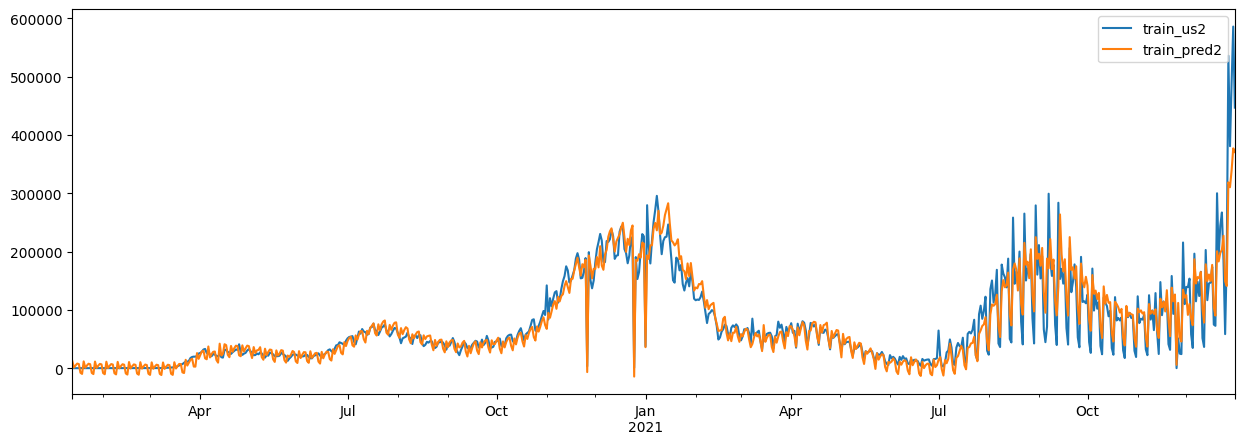

In [107]:
pd.concat([train_us2['new_confirmed'],train_pred2['yhat']], axis=1).plot(figsize=(15,5))
plt.legend(['train_us2', 'train_pred2'])

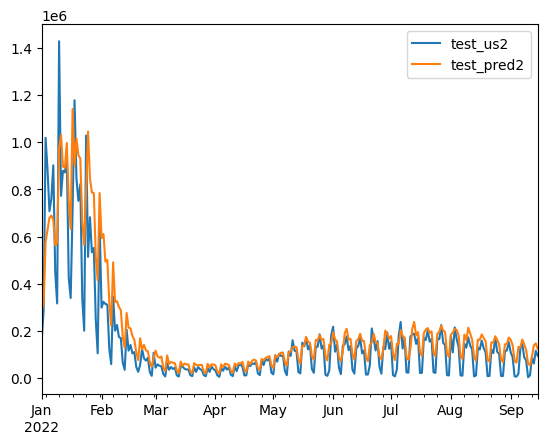

In [108]:
test_pred2=model2.predict(test_us2.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
pd.concat([test_us2['new_confirmed'],test_pred2['yhat']], axis=1).plot( )
plt.legend(['test_us2', 'test_pred2'])

In [114]:
np.sqrt(mean_squared_error(y_true = test_us2['new_confirmed'],
                          y_pred = test_pred2['yhat']))

106707.45635955539

In [113]:
mean_absolute_error(y_true = test_us2['new_confirmed'],
                    y_pred = test_pred2['yhat'])

65253.505629980835

In [116]:
mean_absolute_percentage_error(y_true = test_us2['new_confirmed'],
                    y_pred = test_pred2['yhat'])

130.63729247904658